In [8]:

import mlflow

import os

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
# import bokeh as bh

from datetime import datetime
import taxi_driver.taxi_driver as td


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score

mlflow.sklearn.autolog()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error


from sklearn.dummy import DummyRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



# 📋 Evaluation Function
def eval_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<20} | MSE: {mse:.4f} | R²: {r2:.4f}")

mlflow.set_tracking_uri("http://localhost:5000")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Init Read and cleaning

In [ ]:
#setting some much needed paths 

dataPath = os.path.join("./../data")
csvPath  = os.path.join(dataPath,"CSV")
shpPath  = os.path.join(dataPath,"SHP")

outputPath = os.path.join("outputs")
imagePath = os.path.join(outputPath,"images")



In [4]:
zoneShpPath = os.path.join(shpPath,"taxi_zones.shp")

#combine in one
march_path = os.path.join(dataPath,"yellow_tripdata_2024-03.parquet")
june_path = os.path.join(dataPath,"yellow_tripdata_2024-06.parquet")
nov_path = os.path.join(dataPath,"yellow_tripdata_2024-11.parquet")

taxi_df=td.Taxidf([march_path,june_path,nov_path],
                  sample_fraction=0.3,
                  taxi_zones_shp_path=zoneShpPath)
taxi_df.convert_dates()


/home/itoumpalidis/work/git/nyc_taxi_tips/taxi_driver/taxi_driver.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.taxi_data=pd.concat([self.taxi_data,temp_df])


Sampling the main dataset by selecting only the trips payed with card, tip amount, trip distance and fare amount
that are non negative.

## Data Processing / Feature Engineering

In [ ]:
clean_df=taxi_df.taxi_data.copy()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,do_day,do_hour,pu_date,do_date,congestion_surcharge,Airport_fee,pu_month,do_month,pu_year,do_year
3327050,2,2024-03-14 21:10:53,2024-03-14 21:27:37,NaN,3.40,NaN,None,125,162,0,...,3,21,2024-03-14,2024-03-14,NaN,NaN,3,3,2024,2024
2661989,2,2024-03-27 00:35:48,2024-03-27 00:41:18,1.0,1.30,1.0,N,142,68,1,...,2,0,2024-03-27,2024-03-27,2.5,0.00,3,3,2024,2024
1141272,2,2024-03-12 09:09:32,2024-03-12 09:20:47,5.0,0.99,1.0,N,161,164,1,...,1,9,2024-03-12,2024-03-12,2.5,0.00,3,3,2024,2024
1333747,1,2024-03-13 23:50:22,2024-03-14 00:03:15,1.0,2.40,1.0,N,48,141,1,...,3,0,2024-03-13,2024-03-14,2.5,0.00,3,3,2024,2024
2950867,2,2024-03-29 19:01:49,2024-03-29 19:10:04,1.0,0.72,1.0,N,100,230,1,...,4,19,2024-03-29,2024-03-29,2.5,0.00,3,3,2024,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825172,2,2024-11-17 01:51:18,2024-11-17 01:58:44,1.0,0.69,1.0,N,107,137,1,...,6,1,2024-11-17,2024-11-17,2.5,0.00,11,11,2024,2024
984534,1,2024-11-09 20:48:16,2024-11-09 21:06:58,2.0,2.70,1.0,N,234,141,1,...,5,21,2024-11-09,2024-11-09,2.5,0.00,11,11,2024,2024
2756416,2,2024-11-25 11:08:04,2024-11-25 11:45:08,1.0,8.63,1.0,N,138,230,1,...,0,11,2024-11-25,2024-11-25,2.5,1.75,11,11,2024,2024
2007153,2,2024-11-18 21:20:49,2024-11-18 21:30:45,1.0,2.17,1.0,N,113,48,4,...,0,21,2024-11-18,2024-11-18,-2.5,0.00,11,11,2024,2024


In [44]:
import holidays
us_holidays = holidays.UnitedStates()
grouped_date=taxi_df.grouped_date()
holidays=[datetime.strptime(i,"%Y-%m-%d") in grouped_date for i in list (grouped_date.index)] 

if(not True in holidays):
    print("there are no holidays in the data set")
else:
    print("check for the holidays")

there are no holidays in the data set


Introduce some new features that might help on the modelling

In [9]:
clean_df['is_weekend'] = clean_df['pu_day'].isin([5, 6]).astype(int)
clean_df['is_night'] = clean_df['pu_hour'].apply(lambda h: 1 if h < 6 or h > 21 else 0)


clean_df['dollar_per_mile']=clean_df['fare_amount']/clean_df['trip_distance']
clean_df['tip_to_fare']=clean_df['tip_amount']/clean_df['fare_amount']
clean_df['duration_s']=(clean_df['tpep_dropoff_datetime']-clean_df['tpep_pickup_datetime']).apply(lambda x:x.seconds)
clean_df['speed_kpi']=clean_df['trip_distance']/clean_df['duration_s']

mod_tip = clean_df['tip_amount']%1
clean_df['set_tip_amount_flag']=mod_tip.apply(lambda x:0 if x==0 else 1)

clean_df['Airport_flag']=clean_df['Airport_fee'].apply(lambda x: 0 if x==0 else 1)
clean_df['congestion_surcharge_flag']=clean_df['congestion_surcharge'].apply(lambda x: 0 if x==0 else 1)
clean_df['mta_tax_flag']=clean_df['mta_tax'].apply(lambda x: 0 if x==0 else 1)

filter out outliers, negative values etc. 

In [10]:
#select for now only one vendor id
clean_df = clean_df[clean_df['VendorID']==2]


#will keep only the payment checks
clean_df = clean_df[clean_df['payment_type']==1]

# I will create a sample of only the non_negative
clean_df= clean_df[clean_df['tip_amount']>0]
clean_df= clean_df[clean_df['trip_distance']>0]

# duration >0
clean_df = clean_df[clean_df['duration_s']>0]


#controlling the value between >0 
clean_df=clean_df.loc[(clean_df['fare_amount']>0)]


# tip <100% of the price of the ride
clean_df=clean_df[clean_df['tip_to_fare']<1]

clean_df = clean_df.dropna()

In [29]:
clean_df = clean_df.query('pu_year==2024 and pu_month in [3,6,11] and do_year==2024 and do_month in [3,6,11]')

In [10]:

# encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
# spatial_array = encoder.fit_transform(clean_df[['PULocationID','DOLocationID']])


In [ ]:
# fileName = "clean_sample.csv"
# filePath = os.path.join(csvPath,fileName)
clean_df.to_parquet(f'{dataPath}/clean_sample.parquet')


In [64]:
df['pu_date'] = df['pu_date'].apply(lambda x : pd.to_datetime(x))

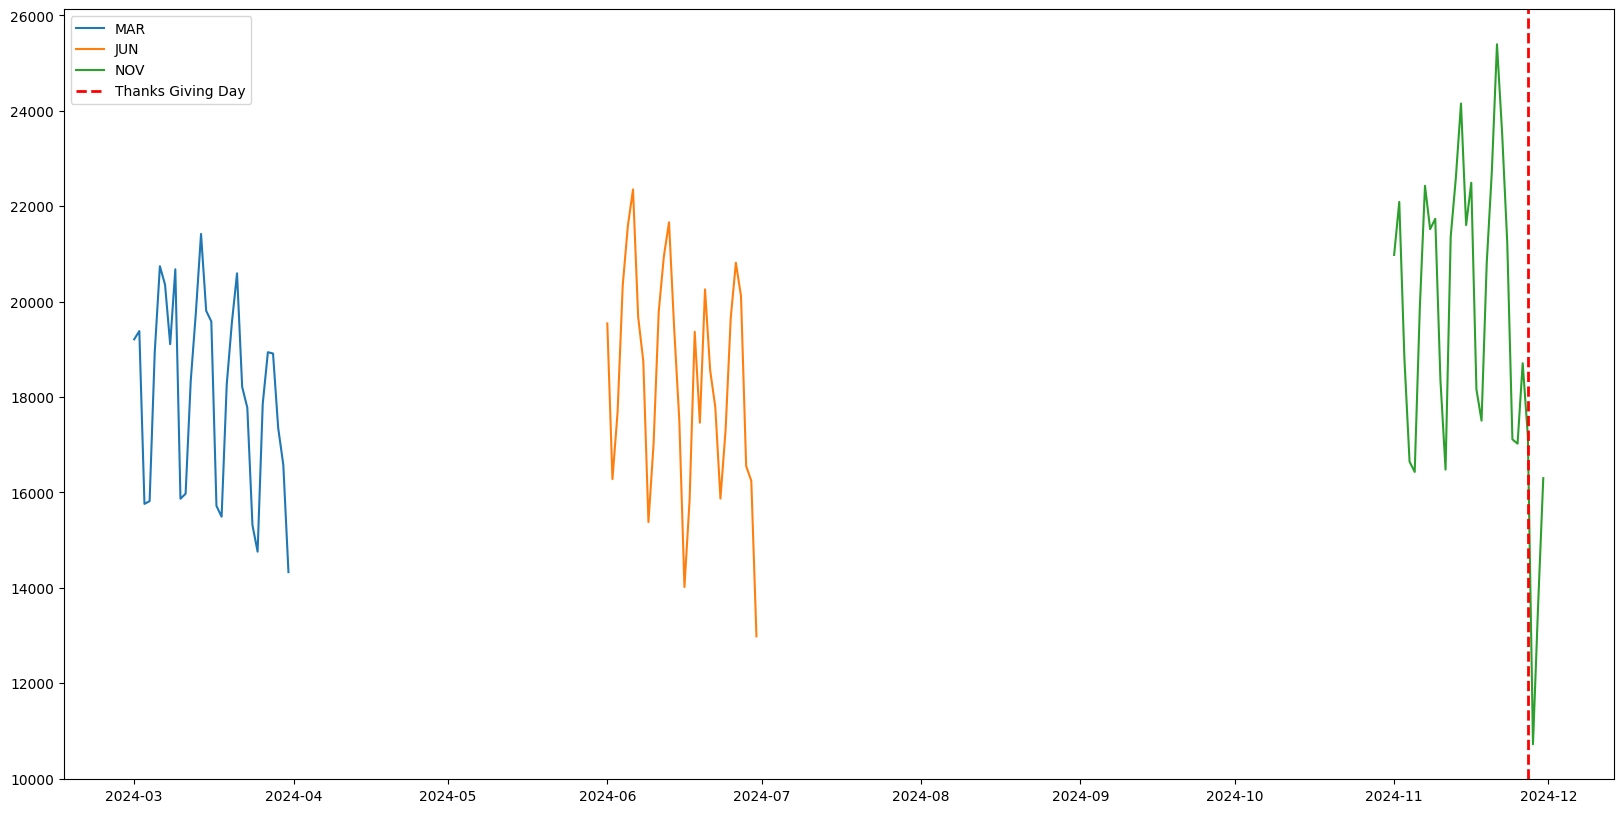

In [82]:
fig,ax = plt.subplots(figsize=(20,10))

start_date = '2024-03-01'
end_date = '2024-04-01'
march_df = df.query('@start_date<=pu_date<@end_date')
ax.plot(march_df['pu_date'],march_df['count'],label='MAR')


start_date = '2024-06-01'
end_date = '2024-07-01'
jan_df = df.query('@start_date<=pu_date<@end_date')
ax.plot(jan_df['pu_date'],jan_df['count'],label='JUN')

start_date = '2024-11-01'
end_date = '2024-12-01'
nov_df = df.query('@start_date<=pu_date<@end_date')
ax.plot(nov_df['pu_date'],nov_df['count'],label='NOV')


specific_date = pd.to_datetime('2024-11-27')
ax.axvline(x=specific_date, color='r', linestyle='--', linewidth=2,label='Thanks Giving Day')
plt.legend()
plt.show()

fig.savefig('outputs/images/temporal_distribution.png')

## Spatial regression 

In [663]:
from sklearn.preprocessing import FunctionTransformer
from spreg import ML_Lag

taxi_df.compute_taxi_zones()

coordsDict = dict(zip(taxi_df.taxi_zones['PULocationID'],list(zip(long,lat))))

groupedDf = clean_df.groupby(['PULocationID','DOLocationID','set_tip_amount_flag','pickup_time','dropoff_time'])[['fare_amount','tip_amount']].mean().reset_index()
groupedDf['PUCoords']=groupedDf['PULocationID'].apply(lambda x:coordsDict[x] if x in coordsDict.keys() else None)
groupedDf[['PULong','PULat']]=pd.DataFrame(groupedDf['PUCoords'].tolist())
groupedDf=groupedDf.dropna()

groupedDf['DOCoords']=groupedDf['DOLocationID'].apply(lambda x:coordsDict[x] if x in coordsDict.keys() else None)
groupedDf[['DOLong','DOLat']]=pd.DataFrame(groupedDf['PUCoords'].tolist())
groupedDf=groupedDf.dropna()


coords = groupedDf[['PULong', 'PULat']].values
w = KNN.from_array(coords, k=5)

# Encode hour as Fourier series
groupedDf['pu_hour_sin'] = np.sin(2 * np.pi * groupedDf['pu_hour'] / 24)
groupedDf['pu_hour_cos'] = np.cos(2 * np.pi * groupedDf['pu_hour'] / 24)

y = groupedDf['set_tip_amount_flag']
X = groupedDf[['fare_amount','pu_hour_sin','pu_hour_cos']]

model = ML_Lag(y, X, w=w)

# View summary
print(model.summary)

## Temporal analysis of the tip amount

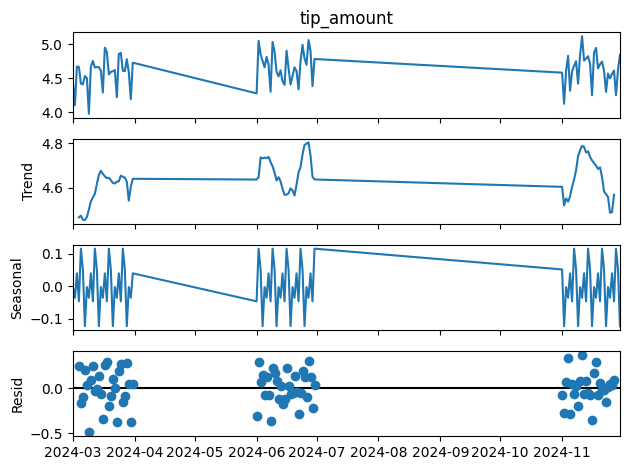

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
daily_tips = clean_df.groupby(clean_df['tpep_pickup_datetime'].dt.date)['tip_amount'].mean()

result = seasonal_decompose(daily_tips, model='additive', period=7)
result.plot()
plt.show()

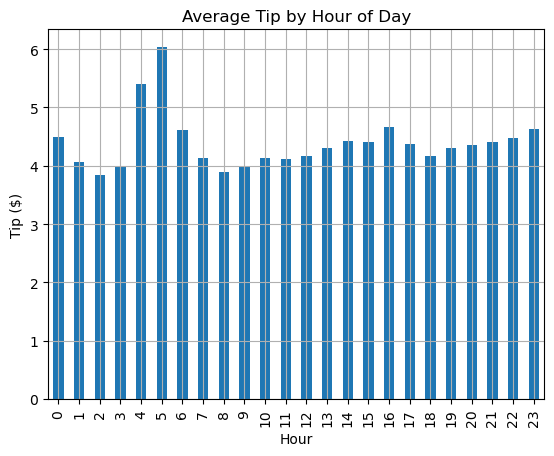

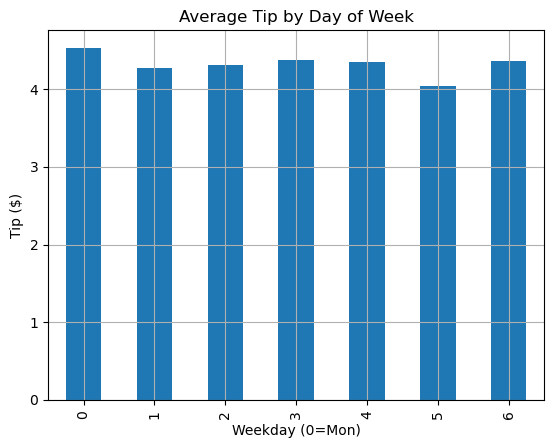

In [ ]:
# Hour of Day
hourly_avg = clean_df.groupby('pu_hour')['tip_amount'].mean()
hourly_avg.plot(kind='bar', title='Average Tip by Hour of Day')
plt.ylabel('Tip ($)')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

# Day of Week
weekday_avg = clean_df.groupby('pu_day')['tip_amount'].mean()
weekday_avg.plot(kind='bar', title='Average Tip by Day of Week')
plt.ylabel('Tip ($)')
plt.xlabel('Weekday (0=Mon)')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import spearmanr

# Convert dates to ordinal (numeric time)
time_numeric = clean_df['tpep_pickup_datetime'].map(pd.Timestamp.toordinal)
corr, pval = spearmanr(time_numeric, clean_df['tip_amount'])

print(f"Spearman Correlation: {corr:.4f}, p-value: {pval:.4e}")

Spearman Correlation: -0.0029, p-value: 1.4924e-05


In [ ]:
Q1 = clean_df['tip_to_fare'].quantile(0.25)
Q3 = clean_df['tip_to_fare'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Check how many values exceed the upper bound
print(f"Upper bound: {upper_bound}")
print((clean_df['tip_to_fare'] > upper_bound).mean())

# Filter based on IQR outlier threshold
clean_df = clean_df[clean_df['tip_to_fare'] <= upper_bound]

Upper bound: 0.4701778105539167
0.029458876636470604


## Classification problem structure

It might be possible to work on a pipeline of two models where the first one classifies if the trip would be more propable to have a set amount regardless the total fare amount and the ones that have a percentage 

In [604]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,f1_score

model = xgb.XGBClassifier()
model.fit(X[:-4637], y[:-4637])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [606]:

X_valid = X[-4637:]
y_valid = y[-4637:]
pred = model.predict(X_valid)

accuracy = f1_score(pred,y_valid)
print(accuracy)

0.6270767055496642


In [607]:
accuracy_score(pred,y_valid)

0.5449644166486953